<a href="https://colab.research.google.com/github/rpll94/Coursera_Capstone/blob/master/Course10_Final_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Italian Traffic Risk and Venues Analysis for vacation decision support.

## Get Italian Provinces Dataset

As we know, Italy is divided in Regions, each Region has a certain number of Provinces (some "big cities"). We want to retrieve a dataset containing informations about each provinces. We can do it exploting web scraping technique, from a Wikipedia table.

In [7]:
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page

In [8]:
url = 'https://it.wikipedia.org/wiki/Province_d%27Italia'
results = requests.get(url)
soup = BeautifulSoup(results.text,"html5lib")
# soup.prettify

Let's parse the table from the source

In [9]:
table = soup.find_all('table', {'class': 'wikitable sortable'})[0]

In [10]:
import pandas as pd
provinces_df = pd.DataFrame(columns=['Province',  'Region', 'Population', 'Area (km2)', 'Density'])

for row in table.find_all("tr"):
  col = row.find_all("td")
  if (col != []):
    province = col[0].text.strip()
    region = col[2].text.strip()
    population = col[3].text.strip()
    area = col[4].text.strip()
    density = col[5].text.strip()
    provinces_df = provinces_df.append({'Province':province, 'Region':region, 'Population':population, 'Area (km2)':area, 'Density':density}, ignore_index=True)

provinces_df['Province'] = provinces_df['Province'].str.replace('\d+', '')
provinces_df['Province'] = provinces_df['Province'].str.replace('[', '')
provinces_df['Province'] = provinces_df['Province'].str.replace(']', '').str.lower()
provinces_df.head()

,Province,Region,Population,Area (km2),Density
0,agrigento,Sicilia,434 870,"3 052,59",142
1,alessandria,Piemonte,421 284,"3 558,83",118
2,ancona,Marche,471 228,"1 936,22",240
3,aosta,Valle d'Aosta,125 666,"3 260,9",39
4,arezzo,Toscana,342 654,"3 233,08",106


## Since we don't have coordinates in this dataset, we add it using geopy library

In [11]:
from geopy.geocoders import Nominatim

def get_latitude(province):
  geolocator = Nominatim(user_agent="italian_province")
  location = geolocator.geocode(province)
  return location.latitude

def get_longitude(province):
  geolocator = Nominatim(user_agent="italian_province")
  location = geolocator.geocode(province)
  return location.longitude

provinces_df['latitude'] = provinces_df.apply(lambda row: get_latitude(row['Province']), axis=1)
provinces_df['longitude'] = provinces_df.apply(lambda row: get_longitude(row['Province']), axis=1)
provinces_df.head()

,Province,Region,Population,Area (km2),Density,latitude,longitude
0,agrigento,Sicilia,434 870,"3 052,59",142,37.312299,13.574650
1,alessandria,Piemonte,421 284,"3 558,83",118,44.834953,8.745030
2,ancona,Marche,471 228,"1 936,22",240,43.480120,13.218791
3,aosta,Valle d'Aosta,125 666,"3 260,9",39,45.737088,7.319665
4,arezzo,Toscana,342 654,"3 233,08",106,43.517202,11.763879


## Import another dataset of italian drive licences.

This is divided by region, and for region we have the list of active licences for this province in this regione. We are interested only in a count per provinces (as we had census per provinces).
We have all this files in a zip file in our Gdrive: since we are using Colab, this is the best way.


In [12]:
import zipfile
import glob
import io
import pandas as pd

licences_df = pd.DataFrame()
for zip_file in glob.glob('/content/drive/MyDrive/Italian incident final/Patenti/*'):
  with zipfile.ZipFile(zip_file, 'r') as zipped_file:
    for zz in zipped_file.namelist():
      licences_df = pd.concat([licences_df, pd.read_csv(io.BytesIO(zipped_file.read(zz)), engine='python', names=['Province', 'Licence Type', 'S/N', 'Date', 'Unknown'], encoding='utf8', error_bad_lines=False)], ignore_index=True)

licences_df.shape

Skipping line 3517763: unexpected end of data
Skipping line 2873090: unexpected end of data
Skipping line 770129: unexpected end of data


(38577892, 5)

First we keep only 'B' type, because in Italy this is the licences to drive cars (which are the most interesting).
Then we count how many licences per province.

In [13]:
licences_bck = licences_df.copy()
licences_df = licences_df[licences_df['Licence Type'] == 'B'][['Province']]
licences_df = licences_df.groupby(by='Province').size().reset_index(name='Number of Lincences')
licences_df['Province'] = licences_df['Province'].str.lower()
licences_df.head(10)

,Province,Number of Lincences
0,agrigento,149533
1,alessandria,259161
2,ancona,296791
3,aosta,79384
4,arezzo,214258
5,ascoli piceno,130356
6,asti,129947
7,avellino,206372
8,bari,722615
9,barletta-andria-trani,205621


## Now we join this dataframe with infos from wikipedia dataset.

In [14]:
infos_df = pd.merge(provinces_df, licences_df, on='Province')
infos_df

,Province,Region,Population,Area (km2),Density,latitude,longitude,Number of Lincences
0,agrigento,Sicilia,434 870,"3 052,59",142,37.312299,13.574650,149533
1,alessandria,Piemonte,421 284,"3 558,83",118,44.834953,8.745030,259161
2,ancona,Marche,471 228,"1 936,22",240,43.480120,13.218791,296791
3,aosta,Valle d'Aosta,125 666,"3 260,9",39,45.737088,7.319665,79384
4,arezzo,Toscana,342 654,"3 233,08",106,43.517202,11.763879,214258
...,...,...,...,...,...,...,...,...
95,vercelli,Piemonte,170 911,"2 081,64",82,45.555383,8.346284,107620
96,verona,Veneto,926 497,"3 096,39",299,45.438496,10.992412,583542
97,vibo valentia,Calabria,160 073,"1 150,64",139,38.626656,16.098693,58437
98,vicenza,Veneto,862 418,"2 722,53",317,45.634859,11.406354,553022


Some adjustment...

In [15]:
infos_df['Population'] = infos_df['Population'].replace("\D", '', regex=True)
infos_df['Population'].head()

0    434870
1    421284
2    471228
3    125666
4    342654
Name: Population, dtype: object

## Add info about percentage of driver

We want to add the percentage of drive licences on total population

In [16]:
infos_df['% of driver'] = round(infos_df['Number of Lincences'] / infos_df['Population'].astype('float64') * 100, 2)
infos_df.sort_values('% of driver', inplace=True, ascending=False)
infos_df.head(5)

,Province,Region,Population,Area (km2),Density,latitude,longitude,Number of Lincences,% of driver
60,palermo,Sicilia,1245826,4 992,249,38.111227,13.352443,2034659,163.32
13,biella,Piemonte,177585,"913,28",192,45.566954,8.086912,116760,65.75
92,udine,Friuli-Venezia Giulia,528791,"4 969,3",106,46.063463,13.235838,345163,65.27
93,varese,Lombardia,890768,"1 198,11",743,45.839713,8.754158,579054,65.01
47,lucca,Toscana,387876,"1 773,22",219,44.017764,10.454430,251622,64.87


Palermo is an outlier according to the % of driver. We cannot consider this city so we drop it

In [17]:
infos_df = infos_df[infos_df['Province'] != 'palermo']

## Let's sort and vizualize the top 5 provinces with the minimum percentage of car driver

In [18]:
infos_df.sort_values('% of driver', inplace=True, ascending=True)
infos_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Province,Region,Population,Area (km2),Density,latitude,longitude,Number of Lincences,% of driver
27,crotone,Calabria,174980,"1 735,68",101,39.187389,16.878282,56139,32.08
18,caltanissetta,Sicilia,262458,"2 138,37",123,37.489941,14.063162,90062,34.31
29,enna,Sicilia,164788,"2 574,7",64,37.566757,14.280747,56639,34.37
0,agrigento,Sicilia,434870,"3 052,59",142,37.312299,13.574650,149533,34.39
21,catania,Sicilia,1103917,3 553,310,37.502235,15.087380,384709,34.85


We discovered that the city with the lower percentage of driver are Crotone, Caltanissetta, Enna, Agrigento and Catania

## Now e want to move to the incidents occured last years. We load a new dataset, from .xlsx file.

In [19]:
import pandas as pd
incident_df = pd.read_excel('/content/drive/MyDrive/Italian incident final/incidenti-per-strada---anni-2004-2018.xlsx')
incident_df = incident_df[['REGIONE', 'PROVINCIA', 'CODICE', 'NOME STRADA', 'incid/km 2018'] + [str(a) for a in range(2004, 2019)]].iloc[:-1, :]
incident_df.head()

,REGIONE,PROVINCIA,CODICE,NOME STRADA,incid/km 2018,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Piemonte,Torino,AA00401,A 04 - Torino-Trieste,2.18,82,65,44,37,40,40,48,49,43,23,50,44,39,57,57
1,Piemonte,Torino,AA00405,A 04 / A 05 - Diramazione Ivrea-Santhià,0.63,10,9,9,9,9,4,12,12,10,4,5,6,8,2,9
2,Piemonte,Torino,AA00501,A 05 - Torino-Aosta,0.82,84,68,92,68,62,66,62,56,43,51,45,35,39,25,46
3,Piemonte,Torino,AA00601,A 06 - Torino-Savona (La Verdemare),0.87,18,19,21,18,22,13,9,18,18,13,5,13,16,9,15
4,Piemonte,Torino,AA02101,A 21 - Torino-Piacenza-Brescia (Autostrada de...,1.09,15,13,14,15,13,8,7,5,7,9,7,8,12,10,10


## Now we want to plot a linechart, showing the number of incident per year for each region

First, we need some adjustments on our dataframe

In [20]:
incident_df_lines = incident_df[['REGIONE'] + [str(a) for a in range(2004, 2019)]]

for col in range(2004, 2019):
  incident_df_lines[str(col)] = incident_df_lines[str(col)].replace('-', '0')
  incident_df_lines[str(col)] = incident_df_lines[str(col)].astype('int')

incident_df_lines = incident_df_lines.groupby(by='REGIONE').sum()
# incident_df_lines.reset_index(drop=False, inplace=True)
incident_df_lines

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
REGIONE,,,,,,,,,,,,,,,
Abruzzo,1744,1528,1532,1373,1193,1350,1447,1274,1157,1154,1109,1036,1020,955,1035
Basilicata,279,282,276,263,239,293,373,320,280,300,284,285,283,250,331
Calabria,1521,1331,1352,1300,1268,1302,1344,1170,1120,1166,1083,1112,1222,1102,1234
Campania,2683,2750,2725,2841,2797,2747,2666,2253,2146,2048,2012,2048,2074,2072,2050
Emilia Romagna,5825,5624,5440,5504,4852,4698,5025,4424,4056,4020,3658,3772,3722,3731,3617
Friuli-Venezia Giulia,1267,1229,1249,1145,1057,1090,999,893,817,788,788,835,819,879,838
Lazio,4969,5149,5080,5026,5007,5333,5260,4797,4543,4323,4177,4177,4026,3875,3951
Liguria,2017,2179,2154,2023,1886,2042,2120,1962,1923,1925,1795,1604,1549,1644,1593
Lombardia,7538,7263,7199,7173,6658,6397,6644,5942,5737,5504,5624,5786,5789,5889,5992


Now we have this kind of pivot table, we can use seaborn to make our plot.

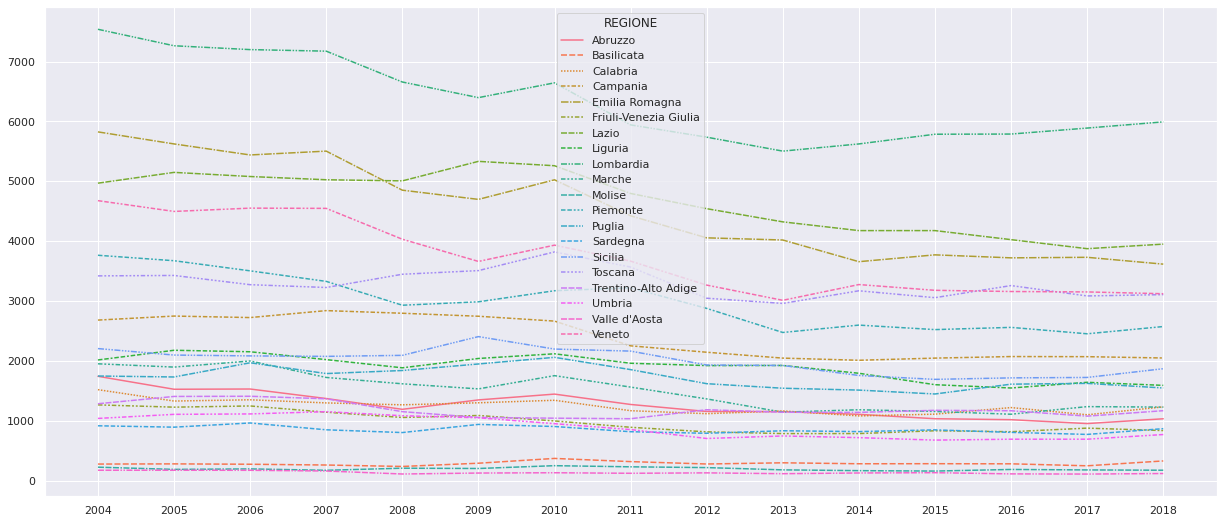

In [21]:
import seaborn as sns
sns.set(rc={'figure.figsize':(21,9)})

sns.lineplot(data=incident_df_lines.T)


# Now we want to see the larger number of incidents, devided per region.
# We exploit a bar chart from seaborn.

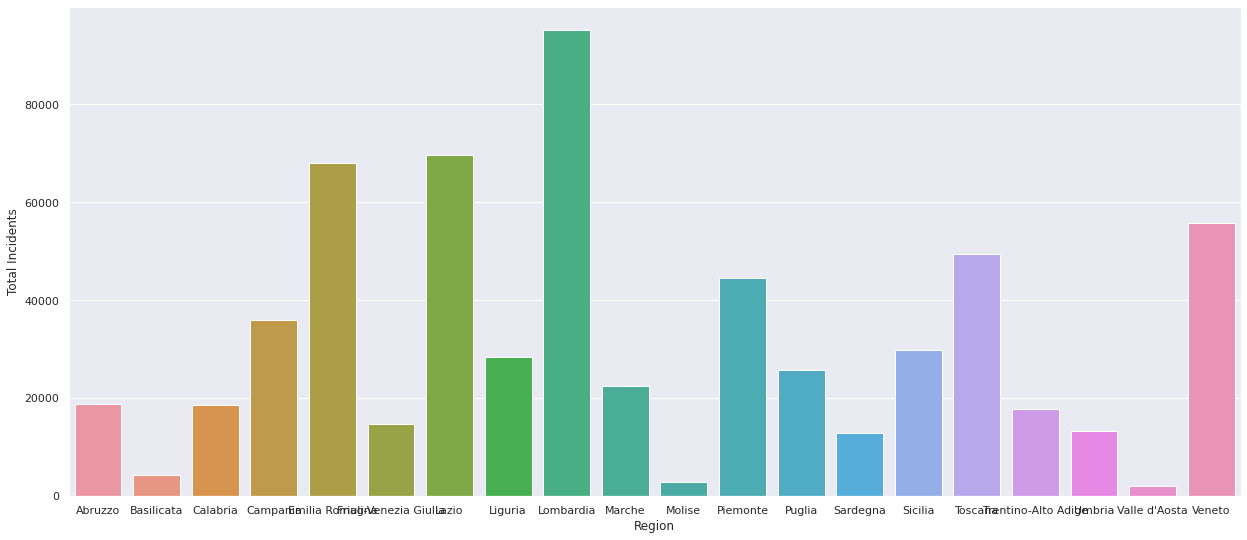

In [22]:
incident_df_bar = pd.DataFrame(incident_df_lines.T.sum())
incident_df_bar.reset_index(drop=False, inplace=True)
incident_df_bar.columns = ['Region', 'Total Incidents']
sns.barplot(data=incident_df_bar, x='Region', y='Total Incidents')

We noticed that region with the lowest number of incidents are also the smallest region, while regione the the higher number of incidents are the largest ones.
So we probably need to take into account information about Area, dividing the number of incidents per km^2.
We want to evaluate this value as an average value for a certain year, so we need also to divide for the number of years we considered: 15, from 2004 to 2018.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


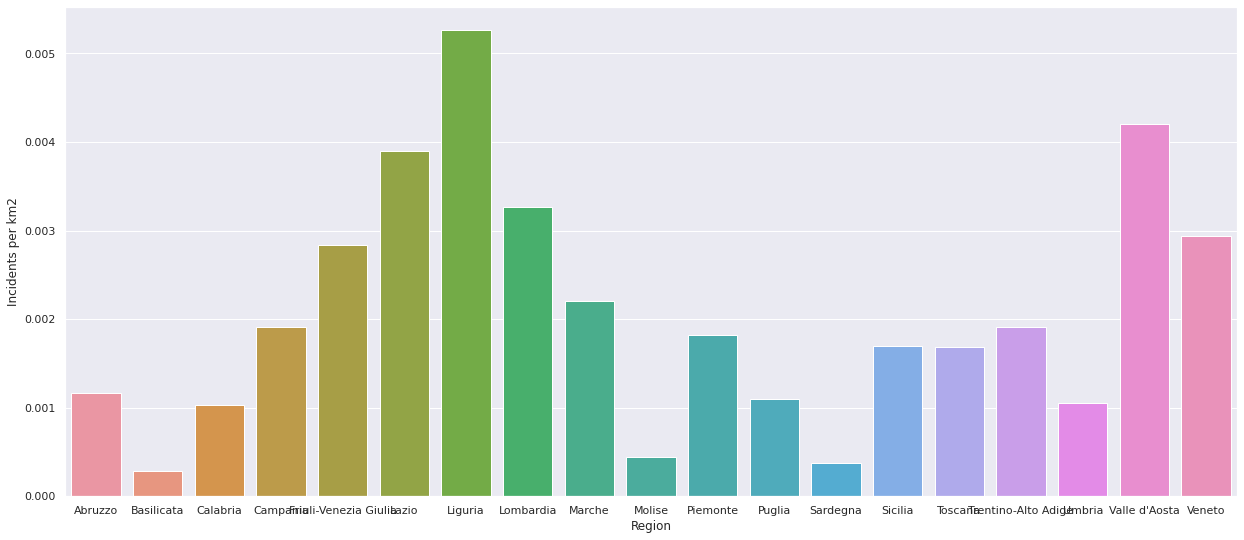

In [23]:
infos_df['Area (km2)'] = infos_df['Area (km2)'].replace("\D", '', regex=True).astype('float64')
infos_df_bar = infos_df.groupby(by='Region').sum()
infos_df_bar = infos_df_bar['Area (km2)'].reset_index(drop=False)
incident_df_bar = pd.merge(incident_df_bar, infos_df_bar, on='Region')
incident_df_bar['Incidents per km2'] = incident_df_bar['Total Incidents'] / 15 / incident_df_bar['Area (km2)']
sns.barplot(data=incident_df_bar, x='Region', y='Incidents per km2')

Results changes: Liguria is the most incident region!
# We can repeat our analysis considering only 2018, analyzing if trend is still the same

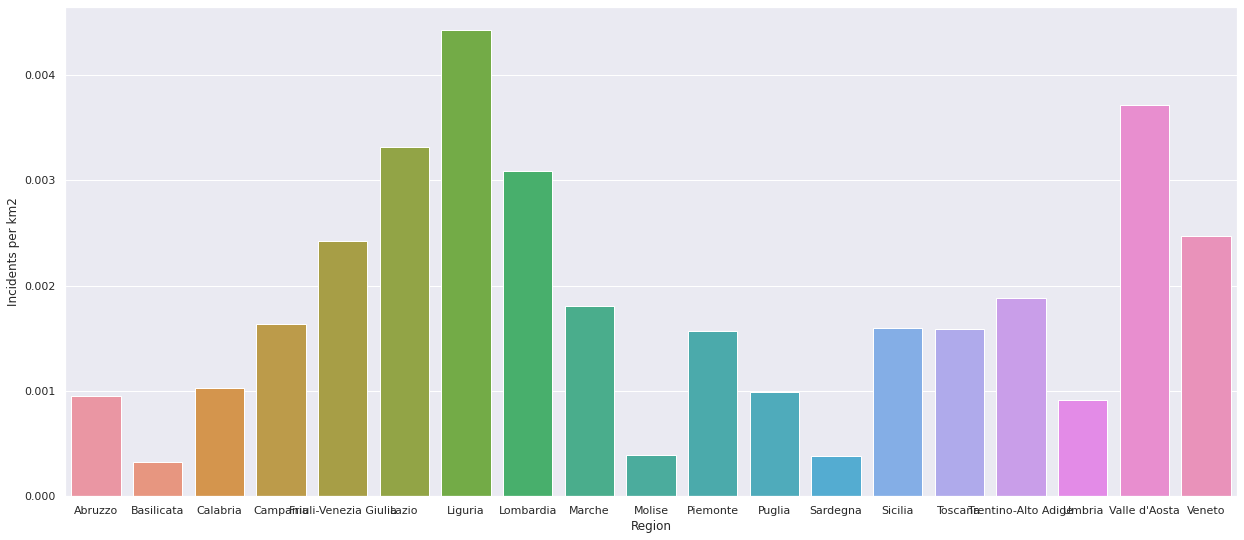

In [24]:
import matplotlib.pyplot as plt
plt.clf()
incident_df_lines_2018 = incident_df_lines['2018'].reset_index(drop=False)
incident_df_lines_2018.columns
incident_df_lines_2018.rename(columns={'REGIONE':'Region'}, inplace=True)
incident_df_bar_2018 = pd.merge(incident_df_lines_2018, infos_df_bar, on='Region')
incident_df_bar_2018['Incidents per km2'] = incident_df_bar_2018['2018'] / incident_df_bar_2018['Area (km2)']
# incident_df_bar_2018
sns.barplot(data=incident_df_bar_2018, x='Region', y='Incidents per km2')

Basically the same results, even if it seems to go better, having a lower number of incidents.

# Now Check if there is any correlation between the number of drive licences per density of population and the number of incident in a Region in 2018. To do this we use the pearson correlation.

In [26]:
import numpy as np
density_df = infos_df
density_df['density'] = infos_df['Density'].replace("\D", '', regex=True).astype('float64')
density_df = density_df[['Region', 'density', 'Number of Lincences']]
density_df = density_df.groupby(by='Region').agg({'density':['mean'], 'Number of Lincences': ['sum']})
corr_df = pd.merge(incident_df_bar_2018[['Region', '2018']], density_df, on='Region')
corr_df.columns = ['Region', '2018', 'Number of Licences', 'Density']
corr_df['Licences per density'] = corr_df['Number of Licences'] / corr_df['Density']
# corr_df
round(np.corrcoef(corr_df['2018'].values, corr_df['Licences per density'].values)[0,1], 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


-0.6

It seems that a negative correlation exists for those two variables. This is not very intuitive. We need to go deep and analyze what it means. Density is the number of people over a certain Area. If Area increase, density decrease. We can suppose that some region has an higher area, so density decrease. If density decrease, drive licences over density increase.
But if number of people doesn't change, number of drive licences should be basically the same as number of incidents, while a bigger area means an higher density. That's what probably this negative correlation could be explained

As our client can drive through the Province it will choose to another one, we can make some cluster in order to see which are the "most density connected" procinces in a certain radius. We try to use DBScan

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

cluster_df = provinces_df[['Province', 'latitude', 'longitude']]
X = np.c_[cluster_df['latitude'].values, cluster_df['longitude'].values]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.12, min_samples=2).fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: ', str(n_clusters_))

Number of clusters:  16


Add cluster as information to our dataframe.

In [28]:
cluster_df['Province Group'] = pd.Series(db.labels_)
cluster_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Province,latitude,longitude,Province Group
0,agrigento,37.312299,13.574650,0
1,alessandria,44.834953,8.745030,1
2,ancona,43.480120,13.218791,2
3,aosta,45.737088,7.319665,1
4,arezzo,43.517202,11.763879,2
...,...,...,...,...
102,vercelli,45.555383,8.346284,1
103,verona,45.438496,10.992412,1
104,vibo valentia,38.626656,16.098693,8
105,vicenza,45.634859,11.406354,1


# Plot a Geo map to vizualize these clusters using folium and foursquare API.

In [29]:
import folium # map rendering library
import matplotlib.cm as cm
import matplotlib.colors as colors

CLIENT_ID = 'EWL1F4APWLEDLJEIN1YA2VUZV4VUI5ZI2XS13P2T5HTGWWRT' # your Foursquare ID
CLIENT_SECRET = 'PKB1DKE4HHLRRLEX01WESNZBQD0DGPPGIFAMHHB0KYK1B1TC' # your Foursquare Secret
ACCESS_TOKEN = 'FSWGHGNOWYZJCNZ3D1PGRW0JKHL4J21MLY3SBUYZFBBQA1NM' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EWL1F4APWLEDLJEIN1YA2VUZV4VUI5ZI2XS13P2T5HTGWWRT
CLIENT_SECRET:PKB1DKE4HHLRRLEX01WESNZBQD0DGPPGIFAMHHB0KYK1B1TC


In [30]:
# create map
map_clusters = folium.Map(location=[cluster_df[cluster_df['Province'] == 'roma']['latitude'].iloc[0], cluster_df[cluster_df['Province'] == 'roma']['longitude'].iloc[0]], zoom_start=5)

# set color scheme for the clusters
x = np.arange(n_clusters_+1)
ys = [i + x + (i*x)**2 for i in range(n_clusters_+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [31]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_df['latitude'], cluster_df['longitude'], cluster_df['Province'], cluster_df['Province Group']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Instead, if we want to cluster italian regions based of risks...

If we define 3 levels of risk (higher, moderate, lower) we can perform a K-means cluster using the number of incident per km^2.

In [32]:
from sklearn.cluster import KMeans
X = incident_df_bar_2018['Incidents per km2'].values
X = X.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, n_jobs=-1, random_state=0)
kmeans.fit(X)
incident_df_bar_2018['Risk Level'] = pd.Series(kmeans.labels_).astype('int')
incident_df_bar_2018

,Region,2018,Area (km2),Incidents per km2,Risk Level
0,Abruzzo,1035,1083184.0,0.000956,0
1,Basilicata,331,1007333.0,0.000329,0
2,Calabria,1234,1201152.0,0.001027,0
3,Campania,2050,1250373.0,0.001640,2
4,Friuli-Venezia Giulia,838,345200.0,0.002428,2
5,Lazio,3951,1192252.0,0.003314,1
6,Liguria,1593,360081.0,0.004424,1
7,Lombardia,5992,1941891.0,0.003086,1
8,Marche,1230,680660.0,0.001807,2
9,Molise,176,446065.0,0.000395,0


# Again, vizualize a Geo Map.

In [33]:
# create map
address = 'Piemonte'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [34]:
# add markers to the map
markers_colors = []
for poi, cluster in zip(incident_df_bar_2018['Region'],incident_df_bar_2018['Risk Level']):

    location = geolocator.geocode(poi)
    lat = location.latitude
    lon = location.longitude

    if cluster == 1:
      cluster_label='High'
    elif cluster == 0:
      cluster_label ='Low'
    elif cluster=='2':
      cluster_label='Middle'


    label = folium.Popup(str(poi) + ' ' + cluster_label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Done! We decide we want a region with the sea, and with lower risk. We are still undiceded between Sardinia, Calabria and Puglia.
# Let's take the provinces in those region (we know the domain so this information will be given) and choose only between provinces connected to at least 1 other province (remember the previous cluster).
# From this we want to retrieve information about the type of venues in there (using foursquare API).

In [35]:
provinces = ['cagliari', 'nuoro', 'oristano', 'sassari', 'sud sardegna', 'catanzaro', 'cosenza', 'crotone', 'reggio calabria', 'vibo valentia']
cluster_df = cluster_df[pd.DataFrame(cluster_df['Province'].tolist()).isin(provinces).any(1).values]
cluster_df = cluster_df[cluster_df['Province Group'] != -1]
cluster_df = cluster_df[['Province', 'latitude', 'longitude']]
cluster_df

,Province,latitude,longitude
18,cagliari,39.216952,9.112851
23,catanzaro,38.829960,16.431557
60,nuoro,40.127683,9.342323
61,oristano,40.026568,8.679642
77,reggio calabria,38.103539,15.639756
89,sud sardegna,39.391652,8.828787
104,vibo valentia,38.626656,16.098693


In [36]:
from pandas import json_normalize
import json
# for search_query in cluster_df['Province'].to_list():
radius = 1000

venues_df = pd.DataFrame()

for province, latitude, longitude in zip(cluster_df['Province'], cluster_df['latitude'], cluster_df['longitude']):
  # url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
  url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, VERSION, radius)

  results = requests.get(url).json()
  results

  # assign relevant part of JSON to venues
  venues = results['response']['venues']

  # tranform venues into a dataframe
  dataframe = json_normalize(venues)
  # keep only columns that include venue name, and anything that is associated with location
  # filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
  filtered_columns = ['categories']

  dataframe_filtered = dataframe.loc[:, filtered_columns]

  dataframe_filtered['categories'] = dataframe_filtered['categories'].apply(lambda value: value[0]['name'] if len(value)>0 else 'Unknown')

  dataframe_filtered['Province'] = province
  # dataframe_filtered['Province latitude'] = latitude
  # dataframe_filtered['Province longitude'] = longitude
  venues_df = pd.concat([venues_df, dataframe_filtered], axis=0)

# Remove 'Unknown' category venues

In [37]:
venues_df = venues_df[venues_df['categories'] != 'Unknown']

# Group on Province and vizualize which categories has the higher number of places of each province

In [38]:
result_df = venues_df.groupby(by=['Province', 'categories']).size().reset_index(name='count')  #agg(lambda x: x.value_counts())
ultimate_df = result_df[['Province', 'count']].groupby(by=['Province']).max().reset_index()
ultimate_df

,Province,count
0,cagliari,3
1,catanzaro,4
2,nuoro,6
3,oristano,3
4,reggio calabria,6
5,sud sardegna,2
6,vibo valentia,5


In [39]:
max_occurences_df = pd.DataFrame()
for p, c in zip(ultimate_df['Province'], ultimate_df['count']):
  max_occurences_df = pd.concat([max_occurences_df, result_df[(result_df['Province'] == p) & (result_df['count'] == c)]])
max_occurences_df

,Province,categories,count
1,cagliari,Bar,3
9,cagliari,Ice Cream Shop,3
10,cagliari,Italian Restaurant,3
36,catanzaro,Pizza Place,4
54,nuoro,Mountain,6
70,oristano,Hotel,3
74,oristano,Plaza,3
80,reggio calabria,Café,6
109,sud sardegna,Italian Restaurant,2
111,sud sardegna,Other Great Outdoors,2


# Suppose we are interested in try the real italian Pizza. We want to have a great choice of Pizza Place. Catanzaro has 4 Pizza Places, and Vibo Valentia 5. Catanzaro and Vibo Valentia are also easely reachable as we discovered in previous clustering based on DBScan. One of these should be our choice!
#They are in Calabria, one of the region with lower number of incidents per area as shown in previous bar chart.